<a href="https://colab.research.google.com/github/ABADIAb/blood-cell-classification-mobilenet/blob/main/image_analysis_%26_classification_of_blood_cells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Artificial Neural Networks and Deep Learning

---

## Image analysis and classification of blood cells


## ⚙️ Import Libraries

In [1]:
# Import necessary libraries
import os

seed = 42 #SEED definition

 # Suppress warnings part
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
##os.environ['PYTHONHASHSEED'] = str(seed)
#os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.simplefilter(action='ignore', category=Warning)


import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Import necessary modules
import logging
import random

#setting of the seed
np.random.seed(seed)
tf.random.set_seed(seed);

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(f"tensor flow version: ", {tf.__version__})


# Import other librariesv for visualiization purpose
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


tensor flow version:  {'2.19.0'}


## ⏳ Load the Data

In [2]:
# File ID in Google Drive
file_id = '1mxWmZYCN5v9kSgkVILBtU82q5X0JzJvD'
destination = 'training_set.npz'

# Download automatically if it doesn't exist
if not os.path.exists(destination):
    print(f"⬇️ Descargando {destination} desde Google Drive...")
    # Use gdown to download public files from Drive
    !gdown --id {'1mxWmZYCN5v9kSgkVILBtU82q5X0JzJvD'} --output {destination}

In [3]:
data = np.load('training_set.npz')
X = data['images']
y = data['labels']

# Define a mapping of labels to their corresponding digit names
labels = {0:'Basophil', 1:'Eosinophil', 2:'Erythroblast', 3:'Immature granulocytes', 4:'Lymphocyte', 5:'Monocyte', 6:'Neutrophil', 7:'Platelet'}

# Save unique labels
unique_labels = list(labels.values())



## 🔎 Inspect Data

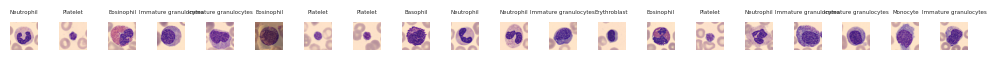

Datset Shape: (13759, 96, 96, 3)


In [4]:
# Display a sample of images to check for outliers
num_img = 20
random_indices = random.sample(range(len(X)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(10, 10))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y[idx][0]]}',fontsize=4)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

#print total number of samples
print("Datset Shape:", X.shape)


In [5]:
#outliers detection function

from scipy import stats
def remove_outliers_zscore2(X, y, threshold):
    """
    Removes outliers from a dataset of images based on the Z-score.

    Returns:
        A NumPy array of images with outliers removed.
    """

    mean = np.mean(X, axis=(1, 2, 3))
    mean = np.mean(X, axis=(1, 2, 3))
    std = np.std(X, axis=(1, 2, 3))

  # Calculate the z-score for each image
    z = np.abs(stats.zscore(mean))

  # Identify outliers
    outliers = np.where(z > threshold)[0]

  # Remove outliers from the dataset
    X_filtered = np.delete(X, outliers, axis=0)
    y_filtered = np.delete(y, outliers, axis=0)
    return X_filtered, y_filtered

In [6]:
X_filtered, y_filtered = remove_outliers_zscore2(X,y, 1.4)

print("Training Data Shape:", X_filtered.shape)
print("Training Data Shape:", y_filtered.shape)

Training Data Shape: (11996, 96, 96, 3)
Training Data Shape: (11996, 1)


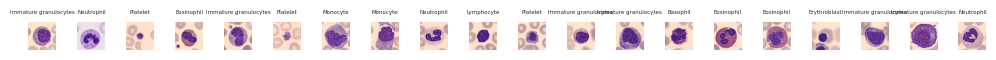

In [7]:
# Display a sample of images from the training-validation dataset
num_img = 20
random_indices = random.sample(range(len(X_filtered)), num_img)

fig, axes = plt.subplots(1, num_img, figsize= (10, 10))

# Iterate through the selected number of images
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(X_filtered[idx]), vmin=0., vmax=1.)
    ax.set_title(f'{labels[y_filtered[idx][0]]}', fontsize=4)
    ax.axis('off')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

## 🔄 Process Data

In [8]:
# Normalize data to the range [0, 1]
X_normalized= (X_filtered / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_categorical= tfk.utils.to_categorical(y_filtered)

In [9]:
# Split data into training and test sets, maintaining class distribution
X_train_val, X_test, y_train_val, y_test = train_test_split(X_normalized, y_categorical, random_state=seed, test_size=0.09, stratify=y_categorical)

# Split data into training and test sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (9824, 96, 96, 3)
Training Label Shape: (9824, 8)
Validation Data Shape: (1092, 96, 96, 3)
Validation Label Shape: (1092, 8)
Test Data Shape: (1080, 96, 96, 3)
Test Label Shape: (1080, 8)


## 💪 Image Augmentaion

860


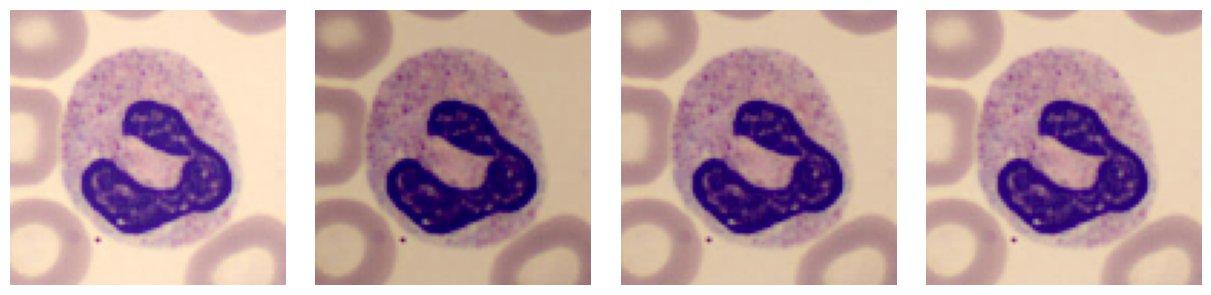

In [10]:
#trial to properly set the brightness
img = X_train[np.random.randint(len(X_train))]
print(np.random.randint(len(X_train)))

# Define a sequential model for image augmentation with random brightness
augmentation = tf.keras.Sequential([
    tfkl.RandomBrightness(0.2, value_range=(0,1)),
])

# Set up the figure and grid layout for displaying images
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images
plt.show()

5191


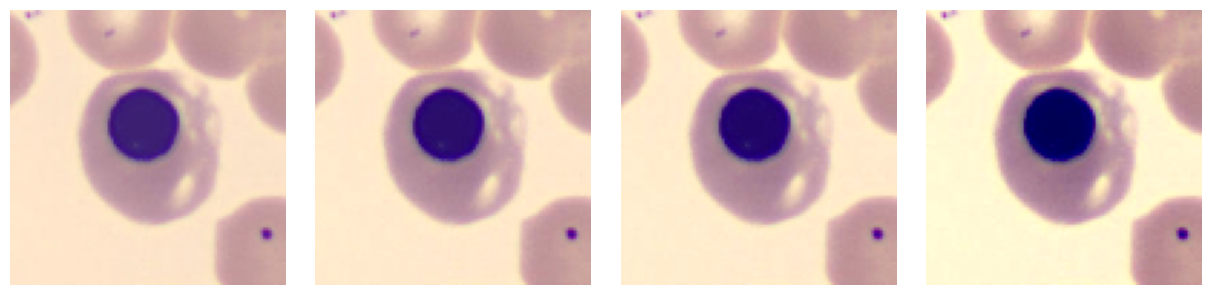

In [11]:
#trial to properly set the contrast
img = X_train[np.random.randint(len(X_train))]
print(np.random.randint(len(X_train)))

# Define a sequential model for image augmentation with random contrast
augmentation = tf.keras.Sequential([
    tfkl.RandomContrast(0.5),
])

# Set up the figure and grid layout for displaying images
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image
augmented_img = np.clip(augmentation(img), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images
plt.show()

In [12]:
# Define a sequential model for image augmentation with various transformations
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    #tfkl.RandomZoom(0.2), #risk of losing the border of the cell
    tfkl.RandomBrightness(0.2, value_range=(0,1)),
    tfkl.RandomContrast(0.5),
], name='Augmentation')
#AUGMENTATION TO BE INSERTED IN THE MODEL LATER

## 🧮 Define Network Parameters

In [13]:
# Input shape for the model
input_shape = X_train.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [14]:
# Number of training epochs
epochs = 500

# Batch size for training
batch_size = 64

# Learning rate: step size for updating the model's weights
learning_rate = 0.001

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rare:", learning_rate)

Epochs: 500
Batch Size: 64
Learning Rare: 0.001


## 🛠️ Transfer Learning

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_96"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

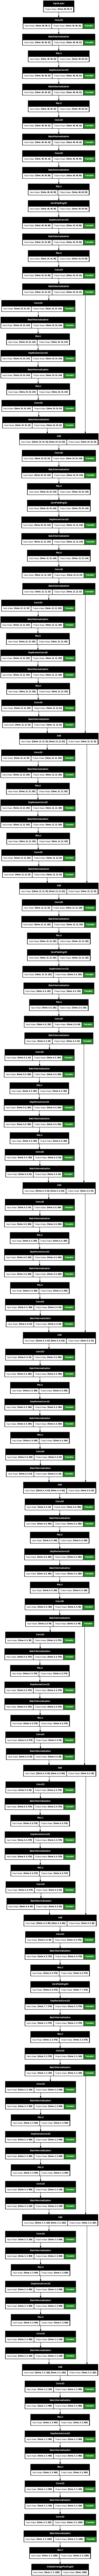

In [15]:
# Initialise MobileNetV3Small model with pretrained weights, for transfer learning
mobilenet = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg',
   # include_preprocessing=None
)

# Display a summary of the model architecture
mobilenet.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(mobilenet, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

In [16]:
# Freeze all layers in MobileNetV3Small to use it solely as a feature extractor
mobilenet.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')

# Define a sequential model for image augmentation with various transformations
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    #tfkl.RandomZoom(0.2), #risk of losing the border of the cell
    tfkl.RandomBrightness(0.2, value_range=(0,1)),
    tfkl.RandomContrast(0.5),
], name='Augmentation')

x = augmentation(inputs)

# Pass augmented inputs through the MobileNetV3Small feature extractor
x = mobilenet(x)

# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_flip_1 (RandomFlip) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_translation_1       │ (None, 96, 96, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_rotation_1          │ (None, 96, 96, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_brightness_2        │ (None, 96, 96, 3)      │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_contrast_2          │ (None, 96, 96, 3)      │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_2 (InputLayer) │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ Conv1 (Conv2D)             │ (None, 48, 48, 32)     │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ bn_Conv1                   │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ Conv1_relu (ReLU)          │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expanded_conv_depthwise    │ (None, 48, 48, 32)     │           288 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expanded_conv_depthwise_BN │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 48, 48, 32)     │             0 │
│ expanded_conv_depthwise_relu    │                        │               │
│ (ReLU)                          │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expanded_conv_project      │ (None, 48, 48, 16)     │           512 │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ expanded_conv_project_BN   │ (None, 48, 48, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_1_expand (Conv2D)    │ (None, 48, 48, 96)     │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ block_1_expand_BN          │ (None, 48, 48, 96)     │           38

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 🧠 Train the Model (without Fine Tuning)

In [17]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

In [18]:
# Train the model with early stopping callback
history = tl_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
#model_filename = 'HW17_CNN_'+str(final_val_accuracy)+'.keras'
model_filename = 'weights.keras'
tl_model.save(model_filename)

# Delete the model to free up resources
del tl_model

Epoch 1/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.5334 - loss: 1.3598 - val_accuracy: 0.8306 - val_loss: 0.4394
Epoch 2/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8278 - loss: 0.4951 - val_accuracy: 0.8901 - val_loss: 0.3093
Epoch 3/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8557 - loss: 0.4132 - val_accuracy: 0.9002 - val_loss: 0.2799
Epoch 4/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8614 - loss: 0.3858 - val_accuracy: 0.9148 - val_loss: 0.2537
Epoch 5/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8746 - loss: 0.3574 - val_accuracy: 0.9148 - val_loss: 0.2429
Epoch 6/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.8855 - loss: 0.3318 - val_accuracy: 0.9103 - val_loss: 0.2416
Epoch 7/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8866 - loss: 0.3258 - val_accuracy: 0.9121 - val_loss: 0.2307
Epoch 8/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8877 - loss: 0.3066 -

## 🛠️ Fine Tuning

In [19]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('weights.keras')

# Display a summary of the model architecture
ft_model.summary(expand_nested=True, show_trainable=True)


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Augmentation (Sequential)   │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_flip_1          │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomFlip)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_translation_1   │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation_1      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_brightness_2    │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomBrightness)          │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_contrast_2      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomContrast)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_96         │ (None, 1280)          │  2,257,984 │   N   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_2          │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1 (Conv2D)         │ (None, 48, 48, 32)    │        864 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn_Conv1               │ (None, 48, 48, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1_relu (ReLU)      │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │        288 │   N   │
│ expanded_conv_depthwise     │                       │            │       │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │        128 │   N   │
│ expanded_conv_depthwise_BN  │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │          0 │   -   │
│ expanded_conv_depthwise_re… │                       │            │       │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ expanded_conv_project  │ (None, 48, 48, 16)    │        512 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 16)    │         64 │   N   │
│ expanded_conv_project_BN    │                       │            │     

 Total params: 2,288,730 (8.73 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 20,498 (80.07 KB)

In [20]:
# Set the MobileNetV3Small model layers as trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True

# Set all MobileNetV3Small layers as non-trainable
for layer in ft_model.get_layer('mobilenetv2_1.00_96').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True, show_trainable=True)


1 Conv1 Conv2D True
4 expanded_conv_depthwise DepthwiseConv2D True
7 expanded_conv_project Conv2D True
9 block_1_expand Conv2D True
13 block_1_depthwise DepthwiseConv2D True
16 block_1_project Conv2D True
18 block_2_expand Conv2D True
21 block_2_depthwise DepthwiseConv2D True
24 block_2_project Conv2D True
27 block_3_expand Conv2D True
31 block_3_depthwise DepthwiseConv2D True
34 block_3_project Conv2D True
36 block_4_expand Conv2D True
39 block_4_depthwise DepthwiseConv2D True
42 block_4_project Conv2D True
45 block_5_expand Conv2D True
48 block_5_depthwise DepthwiseConv2D True
51 block_5_project Conv2D True
54 block_6_expand Conv2D True
58 block_6_depthwise DepthwiseConv2D True
61 block_6_project Conv2D True
63 block_7_expand Conv2D True
66 block_7_depthwise DepthwiseConv2D True
69 block_7_project Conv2D True
72 block_8_expand Conv2D True
75 block_8_depthwise DepthwiseConv2D True
78 block_8_project Conv2D True
81 block_9_expand Conv2D True
84 block_9_depthwise DepthwiseConv2D True
87

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Augmentation (Sequential)   │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_flip_1          │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomFlip)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_translation_1   │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation_1      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_brightness_2    │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomBrightness)          │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_contrast_2      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomContrast)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_96         │ (None, 1280)          │  2,257,984 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_2          │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1 (Conv2D)         │ (None, 48, 48, 32)    │        864 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn_Conv1               │ (None, 48, 48, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1_relu (ReLU)      │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │        288 │   Y   │
│ expanded_conv_depthwise     │                       │            │       │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │        128 │   N   │
│ expanded_conv_depthwise_BN  │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │          0 │   -   │
│ expanded_conv_depthwise_re… │                       │            │       │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ expanded_conv_project  │ (None, 48, 48, 16)    │        512 │   Y   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 16)    │         64 │   N   │
│ expanded_conv_project_BN    │                       │            │     

 Total params: 2,288,730 (8.73 MB)

 Trainable params: 2,200,008 (8.39 MB)

 Non-trainable params: 68,224 (266.50 KB)

 Optimizer params: 20,498 (80.07 KB)

In [21]:
# Set the number of layers to freeze
N = 124

# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True, show_trainable=True)

0 input_layer_2 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Augmentation (Sequential)   │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_flip_1          │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomFlip)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_translation_1   │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation_1      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_brightness_2    │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomBrightness)          │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_contrast_2      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomContrast)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_96         │ (None, 1280)          │  2,257,984 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_2          │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1 (Conv2D)         │ (None, 48, 48, 32)    │        864 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn_Conv1               │ (None, 48, 48, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1_relu (ReLU)      │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │        288 │   N   │
│ expanded_conv_depthwise     │                       │            │       │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │        128 │   N   │
│ expanded_conv_depthwise_BN  │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │          0 │   -   │
│ expanded_conv_depthwise_re… │                       │            │       │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ expanded_conv_project  │ (None, 48, 48, 16)    │        512 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 16)    │         64 │   N   │
│ expanded_conv_project_BN    │                       │            │     

 Total params: 2,288,730 (8.73 MB)

 Trainable params: 1,520,968 (5.80 MB)

 Non-trainable params: 747,264 (2.85 MB)

 Optimizer params: 20,498 (80.07 KB)

In [22]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

In [23]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = callbacks
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
#model_filename = 'Pets_MobileNetV3S_FT_'+str(final_val_accuracy)+'.keras'
model_filename = 'weights.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 15s 54ms/step - accuracy: 0.8523 - loss: 0.4262 - val_accuracy: 0.9167 - val_loss: 0.2008
Epoch 2/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.8972 - loss: 0.2829 - val_accuracy: 0.9231 - val_loss: 0.1991
Epoch 3/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9152 - loss: 0.2372 - val_accuracy: 0.9350 - val_loss: 0.1786
Epoch 4/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.9276 - loss: 0.2078 - val_accuracy: 0.9405 - val_loss: 0.1770
Epoch 5/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9341 - loss: 0.1843 - val_accuracy: 0.9405 - val_loss: 0.1653
Epoch 6/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9368 - loss: 0.1802 - val_accuracy: 0.9368 - val_loss: 0.1662
Epoch 7/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9412 - loss: 0.1636 - val_accuracy: 0.9304 - val_loss: 0.1988
Epoch 8/500
154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9356 - loss: 0.1722 -

## 🕹️ Testing

In [24]:
# Load the saved model
model = tfk.models.load_model('weights.keras')

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ Augmentation (Sequential)   │ (None, 96, 96, 3)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_flip_1          │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomFlip)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_translation_1   │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomTranslation)         │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_rotation_1      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_brightness_2    │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomBrightness)          │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ random_contrast_2      │ (None, 96, 96, 3)     │          0 │   -   │
│ (RandomContrast)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ mobilenetv2_1.00_96         │ (None, 1280)          │  2,257,984 │   Y   │
│ (Functional)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer_2          │ (None, 96, 96, 3)     │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1 (Conv2D)         │ (None, 48, 48, 32)    │        864 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ bn_Conv1               │ (None, 48, 48, 32)    │        128 │   N   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ Conv1_relu (ReLU)      │ (None, 48, 48, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │        288 │   N   │
│ expanded_conv_depthwise     │                       │            │       │
│ (DepthwiseConv2D)           │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │        128 │   N   │
│ expanded_conv_depthwise_BN  │                       │            │       │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 32)    │          0 │   -   │
│ expanded_conv_depthwise_re… │                       │            │       │
│ (ReLU)                      │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ expanded_conv_project  │ (None, 48, 48, 16)    │        512 │   N   │
│ (Conv2D)                    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └                        │ (None, 48, 48, 16)    │         64 │   N   │
│ expanded_conv_project_BN    │                       │            │     

 Total params: 5,310,170 (20.26 MB)

 Trainable params: 1,520,968 (5.80 MB)

 Non-trainable params: 747,264 (2.85 MB)

 Optimizer params: 3,041,938 (11.60 MB)

Accuracy score over the test set: 0.9657
Precision score over the test set: 0.9658
Recall score over the test set: 0.9657
F1 score over the test set: 0.9657


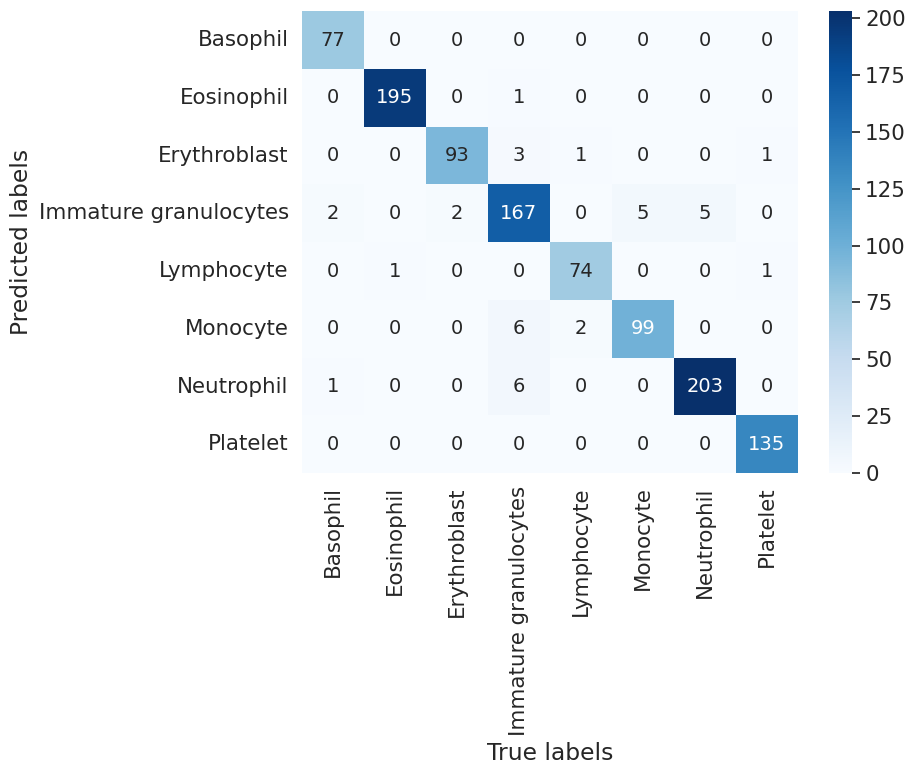

In [25]:
# Predict class probabilities and get predicted classes
test_predictions = model.predict(X_test, verbose=0)
test_predictions = np.argmax(test_predictions, axis=-1)

# Extract ground truth classes
test_gt = np.argmax(y_test, axis=-1)

# Calculate and display test set accuracy
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil','Platelet'], yticklabels=['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil','Platelet'], cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Submission

`.zip` file that includes all the necessary code to run the model. It includes a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [26]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = (X / 255).astype('float32') #normalizzazione di X
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [28]:
import sys
from datetime import datetime

# Generate filename with timestamp
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Create the zip archive (using system command, works on Linux/Colab/Mac)
if os.path.exists('model.py') and os.path.exists('weights.keras'):
    os.system(f'zip {filename} model.py weights.keras')
    print(f"✅ File {filename} created successfully.")
else:
    print("⚠️ model.py or weights.keras not found. Cannot create zip archive.")

# Only attempt to trigger browser download if running in Colab
if 'google.colab' in sys.modules:
    from google.colab import files
    print("⬇️ Starting download in Google Colab...")
    files.download(filename)
else:
    print(f"ℹ️ You are in a local environment. The file {filename} has been saved to your disk.")

✅ File submission_251204_022811.zip created successfully.
⬇️ Starting download in Google Colab...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>